This model is trained using Google Colab Computing Units

# Classification Model


In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/gender-archive.zip', 'r') # dataset uploaded to Google Drive
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
#import library and packages
import tensorflow as tf

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import cv2

## Import Dataset

Dataset downloaded from
https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image & upload to gdrive

In [55]:
train = keras.utils.image_dataset_from_directory(
    directory='/content/gender_rev2/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64)
)

val = keras.utils.image_dataset_from_directory(
    directory='/content/gender_rev2/valid',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64)
)


Found 3491 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [56]:
# normalize dataset (Min-Max Scaling)

#  pixel values are integers that range from 0 (black) to 255 (white) - pixel value, so divide by 255 to bring output from 0 to 1
def normalize_input(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train = train.map(normalize_input)
val = val.map(normalize_input)

## CNN Model Training

In [61]:
# CNN model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten()) # convert to 1D space

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation = 'sigmoid')) # Output has just 1 neuron, because it is a binary classification (0 or 1)


In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 batch_normalization_15 (Ba  (None, 62, 62, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_16 (Ba  (None, 29, 29, 32)        128       
 tchNormalization)                                               
                                                      

In [63]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [64]:
# save model training loss and accuracy parameters
history = model.fit(x=train,
                    epochs=15,
                    validation_data=val)

Epoch 1/15
110/110 [==============================] - 8s 16ms/step - loss: 0.4255 - accuracy: 0.8038 - val_loss: 0.6702 - val_accuracy: 0.5050
Epoch 2/15
110/110 [==============================] - 1s 12ms/step - loss: 0.2347 - accuracy: 0.9003 - val_loss: 0.3770 - val_accuracy: 0.8250
Epoch 3/15
110/110 [==============================] - 1s 12ms/step - loss: 0.1777 - accuracy: 0.9278 - val_loss: 0.2486 - val_accuracy: 0.8950
Epoch 4/15
110/110 [==============================] - 1s 12ms/step - loss: 0.1366 - accuracy: 0.9464 - val_loss: 0.2274 - val_accuracy: 0.9100
Epoch 5/15
110/110 [==============================] - 1s 13ms/step - loss: 0.1113 - accuracy: 0.9542 - val_loss: 0.2217 - val_accuracy: 0.9000
Epoch 6/15
110/110 [==============================] - 2s 19ms/step - loss: 0.0919 - accuracy: 0.9662 - val_loss: 0.2114 - val_accuracy: 0.9000
Epoch 7/15
110/110 [==============================] - 1s 12ms/step - loss: 0.2412 - accuracy: 0.9029 - val_loss: 1.1793 - val_accuracy: 0.5900

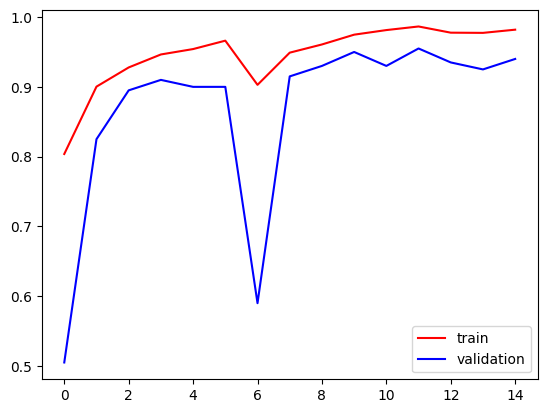

In [65]:
#training & validation set accuracy for each epoch

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

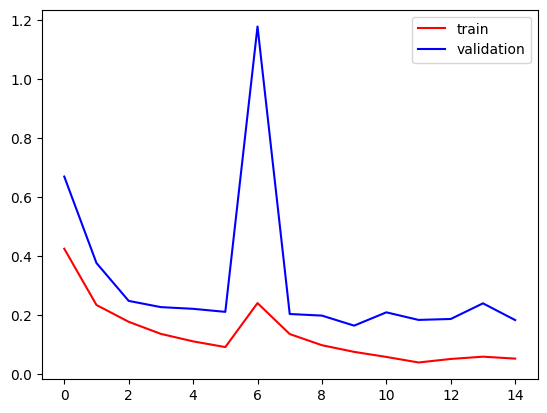

In [66]:
#training & validation set loss(cross entropy) for each epoch

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## Model Testing

In [67]:
# test model on test dataset
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

In [293]:
test = keras.utils.image_dataset_from_directory(
    directory='/content/gender_rev2/test',
    labels='inferred',
    label_mode='int',
    class_names = ['female','male'],
    batch_size=32,
    image_size=(64,64),
    shuffle=False # don't change to true, it will create problem in batch testing - confusion matrix
)

test = test.map(normalize_input)

Found 200 files belonging to 2 classes.


### Method 1- Single Testing of images

In [300]:
y_p = []
y_t = []
for img_batch, labels in test:
    for i, img in enumerate(img_batch):
        image, label = img, labels[i]
        testing_image = image.numpy().reshape(1,64,64,3)

        x = model(testing_image, training=False)
        y_p.append(round(x.numpy()[0][0]))
        y_t.append(label.numpy())

In [301]:
df1 = pd.DataFrame({'Actual': y_t, 'Predicted': y_p})
df1

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
195,1,1
196,1,1
197,1,1
198,1,1


In [302]:
[labels for img, labels in test]

[<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1,

In [303]:
confusion_matrix(y_t,y_p)

array([[91,  9],
       [ 4, 96]])

In [304]:
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       100
           1       0.91      0.96      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



94 % Accuracy for new unseen data

### Method 2 - Batch Testing of Data

In [307]:
y_pred = model.predict(test)

7/7 [==============================] - 0s 6ms/step


In [308]:
y_pred = np.round(y_pred).flatten().astype(int)  # Convert probabilities to binary predictions

y_true = np.concatenate([labels.numpy() for img, labels in test], axis=0).flatten()

# Create a DataFrame for easier visualization (optional)
import pandas as pd
df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

print(df)

     Actual  Predicted
0         0          0
1         0          0
2         0          0
3         0          0
4         0          0
..      ...        ...
195       1          1
196       1          1
197       1          1
198       1          1
199       1          1

[200 rows x 2 columns]


In [309]:
confusion_matrix(y_true, y_pred)

array([[91,  9],
       [ 4, 96]])

In [262]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       100
           1       0.53      0.56      0.55       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.53       200



## Save & Load Model weights and params for future usage

In [243]:
model.save('/content/image-classifier-f-m.keras')

In [245]:
m = keras.models.load_model('/content/image-classifier-f-m.keras')

In [246]:
def predict_new(filepath: str):
    img = cv2.imread(filepath)

    plt.imshow(img)

    img = cv2.resize(img, (64,64))
    test_img = img.reshape((1,64,64,3))

    x = m(test_img/64, training=False)
    output = round(x.numpy()[0][0])
    if output == 0:
        print("female")
    elif output == 1:
        print("male")
    else:
        print('there is some problem')


male


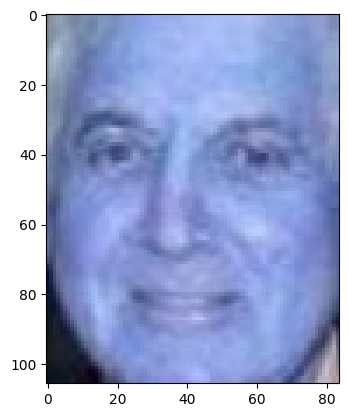

In [247]:
predict_new("/content/gender/consolidated/male/0001.jpg")

female


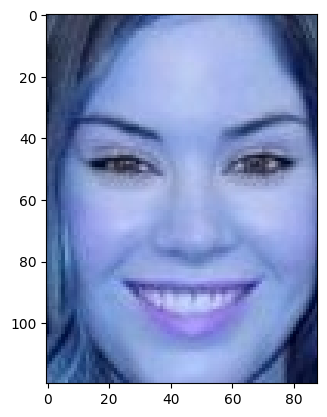

In [335]:
predict_new('/content/gender/consolidated/female/0001.jpg')

In [310]:
!wget -O male.jpg https://cdn2.momjunction.com/wp-content/uploads/2021/02/What-Is-A-Sigma-Male-And-Their-Common-Personality-Trait-624x702.jpg

--2024-01-02 05:54:19--  https://cdn2.momjunction.com/wp-content/uploads/2021/02/What-Is-A-Sigma-Male-And-Their-Common-Personality-Trait-624x702.jpg
Resolving cdn2.momjunction.com (cdn2.momjunction.com)... 104.110.240.170, 104.110.240.123, 2a02:26f0:b200::58dd:1963, ...
Connecting to cdn2.momjunction.com (cdn2.momjunction.com)|104.110.240.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59740 (58K) [image/jpeg]
Saving to: ‘male.jpg’

male.jpg            100%[===================>]  58.34K  --.-KB/s    in 0.005s  

2024-01-02 05:54:19 (11.4 MB/s) - ‘male.jpg’ saved [59740/59740]



male


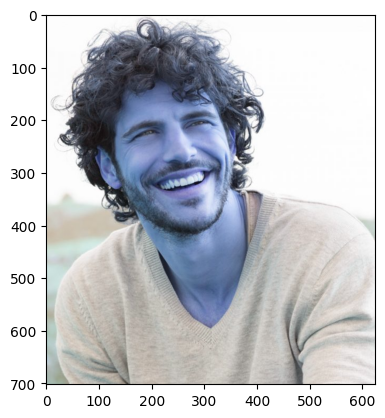

In [331]:
predict_new('/content/male.jpg')

In [312]:
!wget -O male2.jpg https://media.cnn.com/api/v1/images/stellar/prod/230713081542-03-male-grooming-lil-nas-x-restricted.jpg?c=original

--2024-01-02 05:54:57--  https://media.cnn.com/api/v1/images/stellar/prod/230713081542-03-male-grooming-lil-nas-x-restricted.jpg?c=original
Resolving media.cnn.com (media.cnn.com)... 151.101.3.5, 151.101.67.5, 151.101.131.5, ...
Connecting to media.cnn.com (media.cnn.com)|151.101.3.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169525 (166K) [image/jpeg]
Saving to: ‘male2.jpg’

male2.jpg           100%[===================>] 165.55K  --.-KB/s    in 0.008s  

2024-01-02 05:54:58 (19.6 MB/s) - ‘male2.jpg’ saved [169525/169525]



male


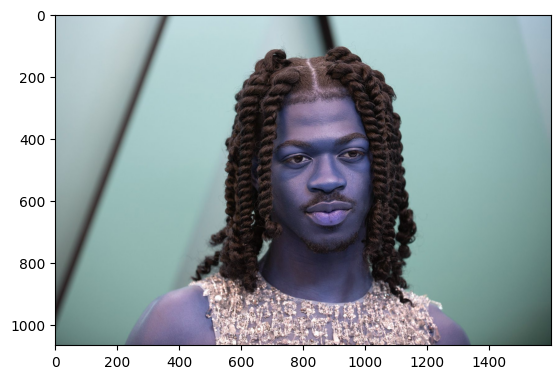

In [330]:
predict_new('male2.jpg')

In [340]:
!wget -O fem.jpg https://cdn.pixabay.com/photo/2021/06/11/12/26/woman-6328478_640.jpg

--2024-01-02 06:01:28--  https://cdn.pixabay.com/photo/2021/06/11/12/26/woman-6328478_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45671 (45K) [image/jpeg]
Saving to: ‘fem.jpg’

fem.jpg             100%[===================>]  44.60K  --.-KB/s    in 0.004s  

2024-01-02 06:01:28 (10.2 MB/s) - ‘fem.jpg’ saved [45671/45671]



female


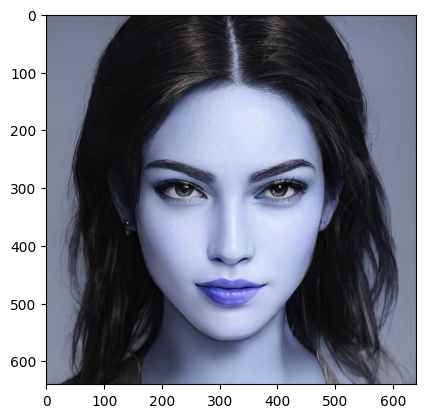

In [341]:
predict_new('fem.jpg')